#Beta Regression Calculation for Purple Mattresses: August 2020 - November 2020

Sources:

 - Yahoo Finance (PRPL and S&P data)
 - FRED (T-Bill data)

In [83]:
#Import Dependencies 
import pandas as pd #For data wrangling
import datetime     #For data cleaning
import statsmodels.api as sm #For the regression



In [84]:
#Import Data

#PRPL:
prpl = pd.read_csv('https://query1.finance.yahoo.com/v7/finance/download/PRPL?period1=1598054400&period2=1606003200&interval=1d&events=history&includeAdjustedClose=true"')


#S&P
spy = pd.read_csv('https://query1.finance.yahoo.com/v7/finance/download/^GSPC?period1=1598054400&period2=1606003200&interval=1d&events=history&includeAdjustedClose=true"')

#3-Month T-Bill
rf = pd.read_csv('https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=TB3MS&scale=left&cosd=2019-10-01&coed=2020-10-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2020-11-22&revision_date=2020-11-22&nd=1934-01-01')


Okay, we have our data imported - We need to get it all into one table. 

The risk-free rate changes by month, and we have data on stock returns by the day
We need to put these all into a table together. Let's track the daily price change in these two securities, 
and then average them by month. We can then compare directly to the risk-free rate

In [85]:
#Create Single Table
df = pd.merge(spy[['Date','Close']], prpl[['Date', 'Close']], on = 'Date', how='outer', suffixes=('_S&P', '_PRPL'))

df
#Our raw returns look like this:

,Date,Close_S&P,Close_PRPL
0,2020-08-24,3431.280029,20.030001
1,2020-08-25,3443.620117,19.549999
2,2020-08-26,3478.729980,19.660000
3,2020-08-27,3484.550049,19.170000
4,2020-08-28,3508.010010,19.100000
...,...,...,...
59,2020-11-16,3626.909912,27.290001
60,2020-11-17,3609.530029,29.350000
61,2020-11-18,3567.790039,29.860001
62,2020-11-19,3581.870117,30.400000


Now, let's group everything by month

In [86]:
#First step: Data Cleaning - we need to first change the dates into a format readable by the computer (a datetime object, not a string of characters)


df['Date'] = df['Date'].apply(lambda x: datetime.date(int(x[:4]), int(x[5:7]), int(x[8: 10])))
df['Month'] = df['Date'].apply(lambda x: x.month)
df


,Date,Close_S&P,Close_PRPL,Month
0,2020-08-24,3431.280029,20.030001,8
1,2020-08-25,3443.620117,19.549999,8
2,2020-08-26,3478.729980,19.660000,8
3,2020-08-27,3484.550049,19.170000,8
4,2020-08-28,3508.010010,19.100000,8
...,...,...,...,...
59,2020-11-16,3626.909912,27.290001,11
60,2020-11-17,3609.530029,29.350000,11
61,2020-11-18,3567.790039,29.860001,11
62,2020-11-19,3581.870117,30.400000,11


We now have expressed our months as integers and created a column by which we can group the data later. 
Now we just need to do the exact same thing for the risk-free data. After, we can compare the two

In [87]:
rf['DATE'] = rf['DATE'].apply(lambda x: datetime.date(int(x[:4]), int(x[5:7]), int(x[8: 10])))
rf['Month'] = rf['DATE'].apply(lambda x: x.month)
rf
#Risk-free data is now in the format we want.

,DATE,TB3MS,Month
0,2019-10-01,1.65,10
1,2019-11-01,1.54,11
2,2019-12-01,1.54,12
3,2020-01-01,1.52,1
4,2020-02-01,1.52,2
5,2020-03-01,0.29,3
6,2020-04-01,0.14,4
7,2020-05-01,0.13,5
8,2020-06-01,0.16,6
9,2020-07-01,0.13,7


So we have our data in the format we want. Let's now isolate the months we're looking at: August, September Octover, and November

In [88]:

# (November's data is not in available yet from FRED, but I found online that it's .007. I'll just add it manually)

rf = rf[['TB3MS', 'Month']].append({'TB3MS': .007, 'Month': 11}, ignore_index=True)
rf = rf = rf.iloc[10:].set_index('Month')
rf

,TB3MS
Month,
8.0,0.100
9.0,0.110
10.0,0.100
11.0,0.007


Almost all our data is now formatted in such a way that it can be compared. We still have our closing prices in dollars, not in % change. Averaging the daily change in price per month is the last thing we need to do before running our regression.

In [89]:
#Now let's loop through the closing prices and track their changes
pbefore = 20.030001
sbefore = 3431.280029	
plist = []
slist = []
i = 0
for row in df.iterrows():
    
    pchange = (row[1]['Close_PRPL'] - pbefore) / pbefore
    schange = (row[1]['Close_S&P'] - sbefore) / sbefore
    if i == 0:
        slist.append(0)
        plist.append(0)
        pbefore = row[1]['Close_PRPL']
        sbefore = row[1]['Close_S&P']
        i += 1
        continue
    plist.append(pchange)
    slist.append(schange)
    pbefore = row[1]['Close_PRPL']
    sbefore = row[1]['Close_S&P']

df['PRPL_Change'] = plist
df['S&P_Change'] = slist

#

In [90]:
#Now we can aggregate our data
df = df.groupby('Month').mean()[['PRPL_Change', 'S&P_Change']].merge(rf, left_index= True, right_index= True)

df
#Here's what it looks like: 

,PRPL_Change,S&P_Change,TB3MS
Month,,,
8,-0.009477,0.003334,0.100
9,0.014445,-0.001788,0.110
10,0.006649,-0.001191,0.100
11,0.006193,0.005691,0.007


Okay, we have expressed everything in terms of a monthly rate of return! Now we can just plug everything in to the Capital Asset Pricing Model!

In [91]:
#The definition of market / asset premium is the return on the market / asset minus the risk-free rate
#Therefore:
df['Mkt_Premium'] = df['S&P_Change'] - df['TB3MS']
df['PRPL_Premium'] = df['PRPL_Change'] - df['TB3MS']

df[['Mkt_Premium', 'PRPL_Premium']]
#Now we have the data exactly as we want it:

,Mkt_Premium,PRPL_Premium
Month,,
8,-0.096666,-0.109477
9,-0.111788,-0.095555
10,-0.101191,-0.093351
11,-0.001309,-0.000807


The asset's beta is just the correlation coefficient for the regression where x is the market premium, and y is the asset premium


In [95]:
#The assets beta is the correlation coefficient for the regression where x is the asset premium, and y is the market premium
#So we just need to do a simple linear regression

x = df['Mkt_Premium']
y = df['PRPL_Premium']
x = sm.add_constant(x)
model = sm.OLS(y, x, hasconst=True).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           PRPL_Premium   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     32.78
Date:                Sun, 22 Nov 2020   Prob (F-statistic):             0.0292
Time:                        13:37:49   Log-Likelihood:                 12.607
No. Observations:                   4   AIC:                            -21.21
Df Residuals:                       2   BIC:                            -22.44
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0015      0.015     -0.104      

#Beta is found to be 0.9424, significant at the 99% level

This must mean that I calculated the beta using a different (most likely smaller) time frame than Yahoo.
But with an R Squared of almost 95%, I must be doing something right

In [96]:
df['Predicted_Premium'] = .9424 * df['Mkt_Premium'] -.0015
df[['PRPL_Premium', 'Predicted_Premium']]

,PRPL_Premium,Predicted_Premium
Month,,
8,-0.109477,-0.092598
9,-0.095555,-0.106849
10,-0.093351,-0.096863
11,-0.000807,-0.002733


#Visualization of the tight, nearly 1:1 correlation

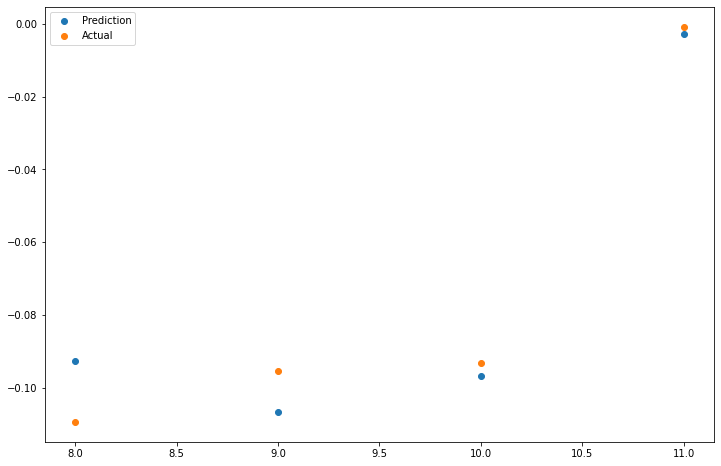

In [97]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 8))
plt.scatter(df.index, df['Predicted_Premium'])
plt.scatter(df.index, df['PRPL_Premium'])

plt.legend(['Prediction', 'Actual'])